In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
import keras_nlp

from datetime import datetime
import utils


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
keras.utils.set_random_seed(69)

In [14]:
df = pd.read_csv("../data/clean/2024-11-27_00-47-15.csv")
df.head()

,Task,Category
0,finish quarterly report,urgent important
1,schedule meeting with client x,urgent important
2,respond to urgent email,urgent not-important
3,clean desk,not-urgent not-important
4,learn new programming language,not-urgent important


# Create Dataset

In [15]:
sentences = df["Task"].to_numpy()
labels = df["Category"].to_numpy()

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))
dataset = dataset.shuffle(len(dataset))

print(sentences[:10])
print()
print(labels[:10])

['finish quarterly report' 'schedule meeting with client x'
 'respond to urgent email' 'clean desk' 'learn new programming language'
 'pay monthly bill' 'exercise regularly' 'read book on leadership'
 'attend networking event' 'plan vacation']

['urgent important' 'urgent important' 'urgent not-important'
 'not-urgent not-important' 'not-urgent important' 'urgent not-important'
 'not-urgent important' 'not-urgent important' 'not-urgent important'
 'not-urgent important']


# Hyperparameters

In [16]:
EMBEDDING_DIM = 100
MAX_LENGTH = 64
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

# Split Dataset

In [17]:
train_size = int(len(dataset) * TRAINING_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

train_ds = train_ds.batch(NUM_BATCHES)
val_ds = val_ds.batch(NUM_BATCHES)

print(f"There are {len(train_ds)} batches for a total of {NUM_BATCHES*len(train_ds)} elements for training.")
print(f"There are {len(val_ds)} batches for a total of {NUM_BATCHES*len(val_ds)} elements for validation.")

There are 10 batches for a total of 1280 elements for training.
There are 2 batches for a total of 256 elements for validation.


# Vectorize Dataset

In [18]:
train_sentences = train_ds.map(lambda x, _: x)  
train_labels = train_ds.map(lambda _, y: y)

In [19]:
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_sentences,
    lowercase=True,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    sequence_length=MAX_LENGTH
)

vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary size = {vocab_size}")

Vocabulary size = 265


In [20]:
label_lookup = keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(train_labels)

print(f"Label size = {label_lookup.vocabulary_size()}")

Label size = 4


In [21]:
for x, y in val_ds.take(1):
    sample_string = x[1]

tokenized_string = tokenizer.tokenize(sample_string)
print(f"Tokenized string is {tokenized_string}")

original_string = tokenizer.detokenize(tokenized_string)
print(f"The original string: {original_string}")

Tokenized string is [ 43  32  68 217  42 149   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
The original string: b'review training material [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'


In [22]:
train_ds_vec = train_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))
val_ds_vec = val_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))

for features, labels in train_ds_vec.take(1):
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

Features: [[240  18  85 ...   0   0   0]
 [ 15 174 100 ...   0   0   0]
 [ 46  78  31 ...   0   0   0]
 ...
 [ 27  97  53 ...   0   0   0]
 [ 28  89 239 ...   0   0   0]
 [ 40  39  17 ...   0   0   0]]
Labels: [1 0 1 0 0 2 1 0 0 0 3 1 1 0 0 1 0 0 2 1 1 3 0 1 3 1 3 2 0 2 2 1 2 0 0 0 2
 3 1 3 0 1 1 0 2 0 0 1 2 0 1 2 0 0 3 0 0 2 1 0 1 2 1 0 0 0 1 1 0 0 0 1 0 0
 0 0 1 1 1 1 2 0 0 1 1 0 0 1 0 3 1 0 1 2 3 0 2 1 0 2 0 0 3 1 2 2 1 2 1 1 0
 1 1 3 1 0 1 2 3 2 1 0 0 3 0 0 3 1]


# Train

In [23]:
model = keras.Sequential([
    keras.Input(shape=(MAX_LENGTH,)),
    keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, "relu"),
    keras.layers.Dense(4, "softmax"),
])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 100)           26500     
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 4)                 28        
                                                                 
Total params: 60,966
Trainable params: 60,966
Non-trainable params: 0
__________________________________________________

In [24]:
history = model.fit(train_ds_vec, epochs=100, validation_data=val_ds_vec)

Epoch 1/100
10/10 [==============================] - 7s 134ms/step - loss: 1.3588 - accuracy: 0.2994 - val_loss: 1.3136 - val_accuracy: 0.3143
Epoch 2/100
10/10 [==============================] - 0s 51ms/step - loss: 1.3184 - accuracy: 0.2986 - val_loss: 1.2663 - val_accuracy: 0.3214
Epoch 3/100
10/10 [==============================] - 1s 53ms/step - loss: 1.2980 - accuracy: 0.3336 - val_loss: 1.2990 - val_accuracy: 0.3500
Epoch 4/100
10/10 [==============================] - 0s 51ms/step - loss: 1.2831 - accuracy: 0.4257 - val_loss: 1.2884 - val_accuracy: 0.5286
Epoch 5/100
10/10 [==============================] - 0s 50ms/step - loss: 1.2522 - accuracy: 0.4535 - val_loss: 1.2257 - val_accuracy: 0.4714
Epoch 6/100
10/10 [==============================] - 1s 53ms/step - loss: 1.1960 - accuracy: 0.4797 - val_loss: 1.1503 - val_accuracy: 0.5357
Epoch 7/100
10/10 [==============================] - 0s 49ms/step - loss: 1.1059 - accuracy: 0.5306 - val_loss: 1.0790 - val_accuracy: 0.5571
Epoch

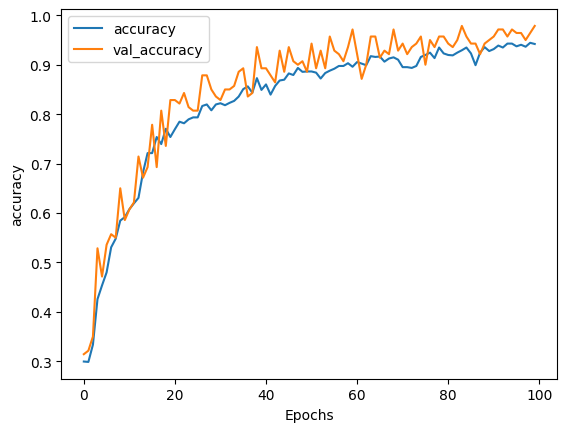

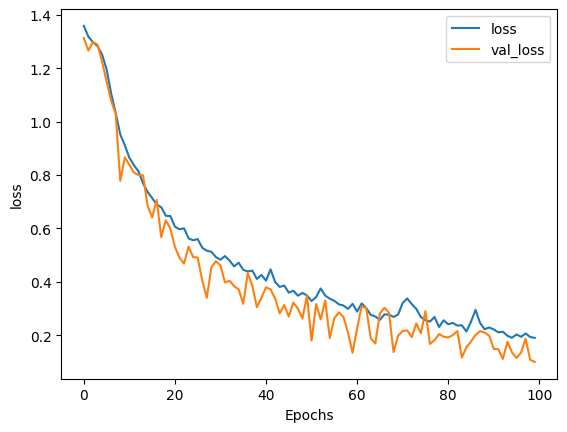

In [25]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Test

In [30]:
task = "Consume all the white bread before it expires tomorrow"
print(f"Input: {task}")

task = utils.lemmatize(task)
print(f"Lemmatized input: {task}")

task_vec = tokenizer(task)
print(f"Vectorized input: {tokenizer.detokenize(task_vec)}")
print(f"\t{[x for x in task_vec.numpy()]}\n")
task_vec = np.reshape(task_vec, (1, len(task_vec)))

prediction = model.predict(task_vec)[0]
print(f"Prediction vector: {prediction}")

label_vocab = label_lookup.get_vocabulary()
for label, probability in zip(label_vocab, prediction):
    percentage = probability * 100
    print(f"\t{label}: {percentage:.5f}%")

best = label_vocab[np.argmax(prediction)]
print(f"Prediction: {best}")

Input: Consume all the white bread before it expires tomorrow
Lemmatized input: consume all the white bread before it expires tomorrow
Vectorized input: b'consume all the white bread before it expires tomorrow [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'
	[15, 94, 72, 73, 262, 102, 13, 153, 119, 35, 96, 123, 48, 14, 68, 48, 216, 14, 48, 145, 67, 48, 21, 53, 17, 231, 97, 259, 68, 48, 73, 57, 58, 67, 68, 94, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1/1 [==============================] - 0s 29ms/step
Prediction vector: [2.5347951e-03 9.9746513e-01 6.9030634e-08 3.3258058e-08]
	not-urgent important: 0.25348%
	not-urgent not-important: 99.74651%
	urgent important: 0.00001%
	urgent not-important: 0.00000%
Prediction: not-urgent not-important


# Save

In [16]:
packed_model = keras.Sequential([
    tokenizer,
    label_lookup,
    model,
])

packed_model.built = True
now = datetime.now().strftime(r"%Y-%m-%d_%H-%M-%S")
packed_model.save(f"../model/{now}.keras")